<a id="title_ID"></a>
# Read and Plot A Kepler Data Validation Timeseries File

 This notebook tutorial demonstrates how to load and plot the contents of a Kepler data validation timeseries (dvt) file.  We will plot the flux timeseries contained within the file.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Introduction

Kepler does a search of the postage-stamp data, taken at either short (60-second) or long (30-minute) cadence. For every signal it identifies with its Transit Planet Search (TPS) module, it creates something called a Threshold Crossing Event (TCE).  TCEs are periodic signals that exceed a nominal signal-to-noise requirement. Some are consistent with transiting planets, others are eclipsing binaries, and others are more consistent with variable stars or noise in the data. 

The Data Validation (DV) module of the pipeline produces a set of products that can help validate the quality of a TCE. The DV products include a time series file of the flattened light curve that was searched, where the light curves from different Quarters are stitched together to mitigate offsets between them, and relevant statistics for each signal (dvt.fits).  DV reports that consist of a few diagnostic plots and relevant statistics (dvs.pdf for individual signals, dvr.pdf for all signals found in the TIC object), and an xml file (dvr.xml) that contains the results of the planet transit fit, are also created and provided.  We will be exploring a dvt.fits file in this tutorial.

This tutorial will refer to a couple Kepler-related terms that we define here.
* Quarter = Kepler rotated 90 degrees once every 3 months.  Each rotation resulted in a separate collection sequence known as a "Quarter".  While the field-of-view did not change, other details and parameters did, including where some targets fell on the detectors and even whether they got data at all depending on where they were located.  Most Quarters contain a single long cadence file, and a few short cadence sequences, but there are some exceptions.
* KIC ID = "Kepler Input Catalog" identifier, used to refer to different targets in the Kepler field-of-view.  With some exceptions, each objects in the Kepler field-of-view has a single, unique KIC ID.  Files are often named based on the KIC ID the data are for.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* BKJD = Kepler Barycentric Julian Date, the timestamp measured in BJD, but offset by 2454833.0.  I.e., BKJD = BJD - 2454833.0
* Cadence = The interval between flux measurements, nominally ~1 minute for short cadence and ~30 minutes for long cadence.
* TCE = Threshold Crossing Event, periodic signals found by the Kepler pipeline that exceed a nominal signal-to-noise ratio.

## Obtaining The DVT Series File

We will read the data validation file of KIC 11446443 (also known as TrES-2, which has at least one planet, TrES-2 b) using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve Kepler files, we won't show how to search and retrieve Kepler DVT files in this tutorial.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
dvt_file = "https://archive.stsci.edu/missions/kepler/dv_files/0114/011446443/kplr011446443-20160128150956_dvt.fits"

## Understanding The DVT File Structure

The DVT FITS file consits of a primary HDU with metadata stored in the header, and one FITS extension HDU per TCE found in the light curve of the specified KIC ID.  These extensions contain the detrended flux time series phased to the orbital period of the signal, stored as a binary FITS table.  The last extension HDU always contains some additional statistics about the search, also stored in a binary FITS table.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.

In [3]:
fits.info(dvt_file)

Filename: /home/runner/.astropy/cache/download/url/c56907f3f143ecacc3cd62997839d56d/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In this case, KIC 011446443 has a single TCE identified, and the "statistics" extension in the last HDU, as expected.  Let's examine the TCE extension in more detail using the astropy.fits `getdata` function and see what columns are available.

In [4]:
fits.getdata(dvt_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

In addition to the timestamps in BKJD format, there is a column containing the times phased to the orbital period of the signal, and there are several columns of fluxes.  LC_INIT is the "unwhitened" fluxes, LC_WHITE are the "whitened" fluxes.  The MODEL_INIT and MODEL_WHITE fluxes are the corresponding model fluxes based on the best fit to the signal.

## Plotting The Timeseries Fluxes.

Let's open the FITS file and extract some metadata from the headers, and also store some of the columns from the TCE signal for use later when we plot the results.

In [5]:
with fits.open(dvt_file, mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and Kepler magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['KEPMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    period = hdulist[1].header['TPERIOD']
    duration = hdulist[1].header['TDUR']
    epoch = hdulist[1].header['TEPOCH']
    depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in BKJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdulist[1].data['TIME']
    phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    model_fluxes_init = hdulist[1].data['MODEL_INIT']

Let's make a plot of the detrended fluxes and model fluxes vs. orbital phase.

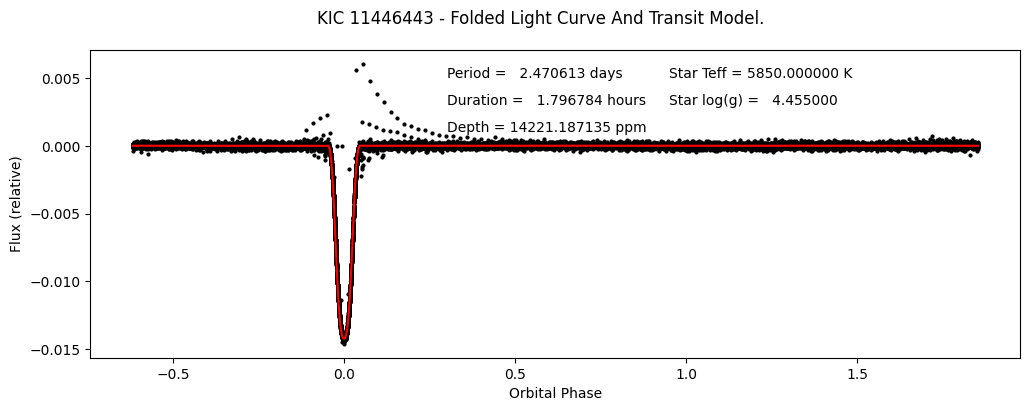

In [6]:
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,4))

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(phases[sort_indexes], fluxes_init[sort_indexes], 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('KIC 11446443 - Folded Light Curve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Orbital Phase")

# Let's add some text in the top-right containing some of the fit parameters.
plt.text(0.3, 0.005, "Period = {0:10.6f} days".format(period))
plt.text(0.3, 0.003, "Duration = {0:10.6f} hours".format(duration))
plt.text(0.3, 0.001, "Depth = {0:10.6f} ppm".format(depth))
plt.text(0.95, 0.005, "Star Teff = {0:10.6f} K".format(star_teff))
plt.text(0.95, 0.003, "Star log(g) = {0:10.6f}".format(star_logg))

plt.show()

## Examining The Statistics Extension

The statistics extension HDU contains the Single Event Statistics ("SES") correlation time series and the SES normalization time series for each of the pipeline's search durations.  For this target, since there is only one TCE, the statistics extension is in HDU extension #2. For more information, see [Tenebaum et al. 2012, ApJS, 199, 24](http://adsabs.harvard.edu/abs/2012ApJS..199...24T) and [Twicken et al. 2018, PASP, 130, 6](http://adsabs.harvard.edu/abs/2018PASP..130f4502T) for a description of the DV statistics. These statistics are used to calculate the Combined Differential Photometric Precision ("CDPP") time series ([Gilliland et al. 2011, ApJS, 197, 6](http://adsabs.harvard.edu/abs/2011ApJS..197....6G)).

In [7]:
fits.getdata(dvt_file, ext=2).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B24.24'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_5_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_6_0'; format = 'E'; disp = 'E14.7'
    nam

## About this Notebook

**Authors:** Scott W. Fleming, Susan E. Mullally

**Updated On:** 2019-01-15

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 